In [1]:
import pandas as pd
import panel as pn
pn.extension('plotly')

from app_bilan_observations import AppBilanObservations
from datastore_observations import DataStoreObservations
from viewer_bilan_observations import ViewerMeteoObservations, ViewerBilanObservations


APPLICATION_ID = 'ZlFGb1VCNzdlQ3c5QmhSMU1IbE8xQTluOE0wYTpUS3l1YkcweGJmSTJrQlJVaGNiSkNHTXczdHNh'
REF_STATION_NAME = 'La Petite Claye'
REF_STATION_ALTITUDE = 50.
REF_STATION_LAT = 48.541356
REF_STATION_LON = -1.615400
NN_RAYON_KM = 35.
PERIODE = (pd.Timestamp("2025-01-17T07:00:00Z"),
           pd.Timestamp("2025-01-18T06:00:00Z"))


params = dict(
    lire_liste_stations=True,
    lire_donnee_liste_stations=True,
    lire_donnee_ref=True,
    application_id=APPLICATION_ID,
    ref_station_name=REF_STATION_NAME,
    ref_station_altitude=REF_STATION_ALTITUDE,
    ref_station_lat=REF_STATION_LAT,
    ref_station_lon=REF_STATION_LON,
    nn_rayon_km=NN_RAYON_KM,
    periode=PERIODE)
    
datastore = DataStoreObservations(**params)
view_meteo = ViewerMeteoObservations(datastore=datastore)
view_bilan = ViewerBilanObservations(datastore=datastore)
AppBilanObservations(
    datastore=datastore,
    view_meteo=view_meteo,
    view_bilan=view_bilan).servable()

Column
    [0] Markdown(str)
    [1] Column
        [0] Markdown(str)
        [1] Checkbox(name='Lire la liste d..., value=True)
        [2] Checkbox(name='Lire la donnée p..., value=True)
        [3] Checkbox(name='Lire la donnée p..., value=True)
        [4] ParamMethod(method, _pane=Column, defer_load=False)
        [5] ParamFunction(function, _pane=Column, defer_load=False)
        [6] ParamFunction(function, _pane=Column, defer_load=False)
        [7] ParamFunction(function, _pane=Column, defer_load=False)
        [8] ParamFunction(function, _pane=Column, defer_load=False)
        [9] ParamFunction(function, _pane=Column, defer_load=False)
    [2] Column
        [0] Markdown(str)
        [1] ParamFunction(function, _pane=Str, defer_load=False)
    [3] Column
        [0] Markdown(str)
        [1] ParamFunction(function, _pane=Str, defer_load=False)

In [3]:
df = pd.DataFrame(columns=['a', 'b'])
df.columns[1]

'b'

In [1]:
import param
import panel as pn
df = param.DataFrame()
df.name = "bob"

a = pn.Param(df, widgets={df.name: dict(type=pn.widgets.Tabulator)})
a.widgets

{'bob': {'type': panel.widgets.tables.Tabulator}}

In [76]:
import datetime as dt
import pandas as pd
pn.extension()

w = pn.widgets.DatetimeRangeInput(start=None, end=None, name="YYYY-mm-dd HH:MM:SS")
w

DatetimeRangeInput(name='YYYY-mm-dd HH:MM:SS')

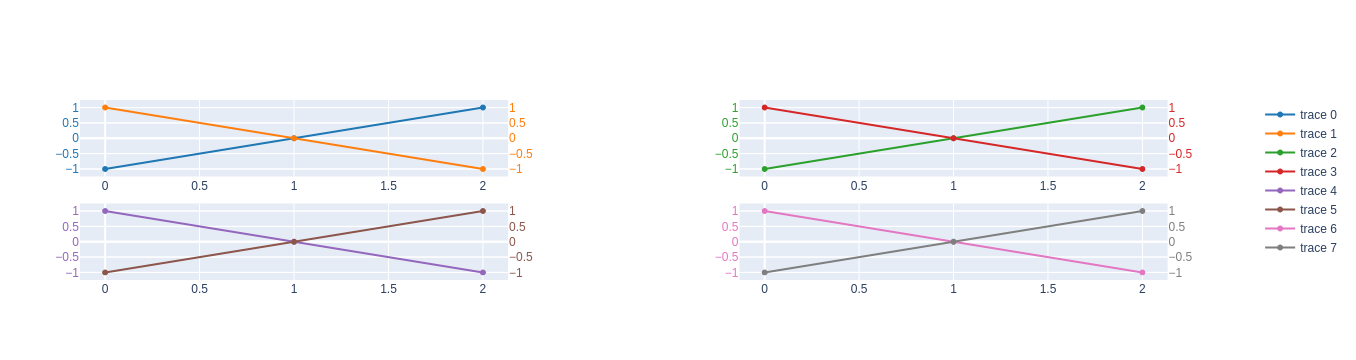

In [49]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.colors import DEFAULT_PLOTLY_COLORS


rows = 2
cols = 2
fig = make_subplots(rows=rows, cols=cols, specs=[[{"secondary_y": True}] * cols] * rows)

s = pd.Series([-1, 0, 1])
s2 = s * -1
row = 1
col = 1
k = 0
fig.add_trace(go.Scatter(x=s.index, y=s, line_color=DEFAULT_PLOTLY_COLORS[k]), secondary_y=False, row=row, col=col)
fig.update_yaxes(row=row, col=col, secondary_y=False, color=DEFAULT_PLOTLY_COLORS[k % len(DEFAULT_PLOTLY_COLORS)])
k += 1
fig.add_trace(go.Scatter(x=s2.index, y=s2, line_color=DEFAULT_PLOTLY_COLORS[k]), secondary_y=True, row=row, col=col)
fig.update_yaxes(row=row, col=col, secondary_y=True, color=DEFAULT_PLOTLY_COLORS[k % len(DEFAULT_PLOTLY_COLORS)])
col = 2
k += 1
fig.add_trace(go.Scatter(x=s.index, y=s, line_color=DEFAULT_PLOTLY_COLORS[k]), secondary_y=False, row=row, col=col)
fig.update_yaxes(row=row, col=col, secondary_y=False, color=DEFAULT_PLOTLY_COLORS[k % len(DEFAULT_PLOTLY_COLORS)])
k += 1
fig.add_trace(go.Scatter(x=s2.index, y=s2, line_color=DEFAULT_PLOTLY_COLORS[k]), secondary_y=True, row=row, col=col)
fig.update_yaxes(row=row, col=col, secondary_y=True, color=DEFAULT_PLOTLY_COLORS[k % len(DEFAULT_PLOTLY_COLORS)])
row = 2
col = 1
k += 1
fig.add_trace(go.Scatter(x=s2.index, y=s2, line_color=DEFAULT_PLOTLY_COLORS[k]), secondary_y=False, row=row, col=col)
fig.update_yaxes(row=row, col=col, secondary_y=False, color=DEFAULT_PLOTLY_COLORS[k % len(DEFAULT_PLOTLY_COLORS)])
k += 1
fig.add_trace(go.Scatter(x=s.index, y=s, line_color=DEFAULT_PLOTLY_COLORS[k]), secondary_y=True, row=row, col=col)
fig.update_yaxes(row=row, col=col, secondary_y=True, color=DEFAULT_PLOTLY_COLORS[k % len(DEFAULT_PLOTLY_COLORS)])
col = 2
k += 1
fig.add_trace(go.Scatter(x=s2.index, y=s2, line_color=DEFAULT_PLOTLY_COLORS[k]), secondary_y=False, row=row, col=col)
fig.update_yaxes(row=row, col=col, secondary_y=False, color=DEFAULT_PLOTLY_COLORS[k % len(DEFAULT_PLOTLY_COLORS)])
k += 1
fig.add_trace(go.Scatter(x=s.index, y=s, line_color=DEFAULT_PLOTLY_COLORS[k]), secondary_y=True, row=row, col=col)
fig.update_yaxes(row=row, col=col, secondary_y=True, color=DEFAULT_PLOTLY_COLORS[k % len(DEFAULT_PLOTLY_COLORS)])

fig.show()

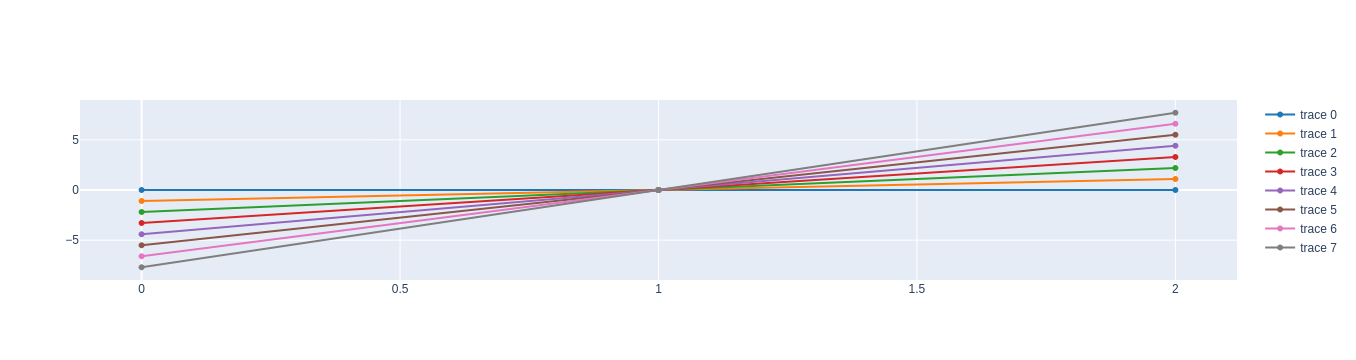

In [48]:
fig = go.Figure()
for k in range(8):
    fig.add_trace(go.Scatter(x=s.index, y=s * 1.1 * k, line_color=DEFAULT_PLOTLY_COLORS[k]))
fig.show()